<h1 style='color: darkblue; font-weight: bold; text-align: center;'>Text Classifier</h1>

<p style='text-align: center;'> This notebook aims to store the code for a text classifier built using NLP techniques.. </p>

### Setting up

In [54]:
from zipfile import ZipFile
import requests as req
import time
import os

DATASET_FN = './data/sentiment_labelled_sentences.zip'
  
def extract_data(fn):
  with ZipFile(fn, 'r') as zf:
    zf.extractall('./data/')
    
def rename_data_folder(fn, new_name):
  if os.path.exists(fn):
    os.rename(fn, new_name)
    time.sleep(.5)

extract_data(DATASET_FN)
rename_data_folder('./data/sentiment labelled sentences/', './data/labelled_data')

### Getting the data

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

filepaths = dict({
  'amazon': './data/labelled_data/amazon_cells_labelled.txt',
  'yelp': './data/labelled_data/yelp_labelled.txt',
  'imdb': './data/labelled_data/imdb_labelled.txt'
})

dfs = list([])
for source, filepath in filepaths.items():
  df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
  df['source'] = source
  dfs.append(df)

df = pd.concat(dfs)
df.head()

,sentence,label,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon


### Quick EDA

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 747
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2748 non-null   object
 1   label     2748 non-null   int64 
 2   source    2748 non-null   object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB


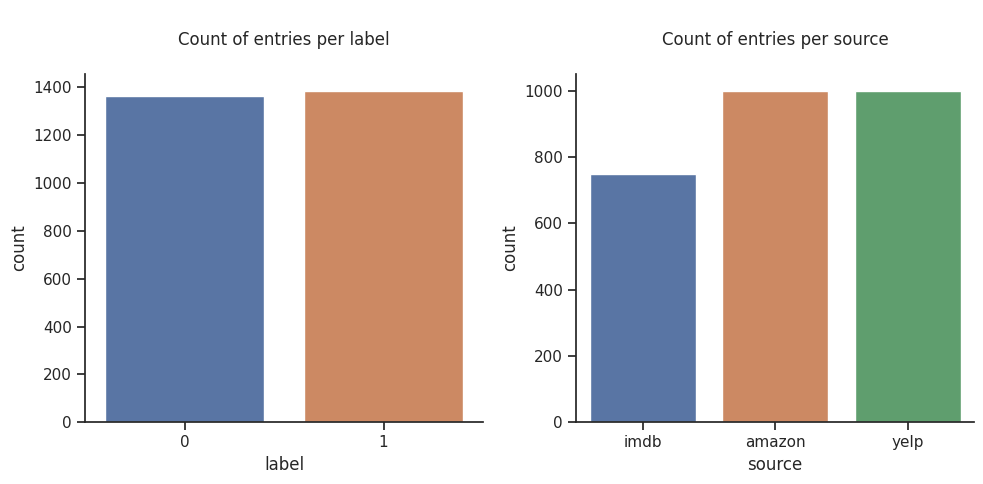

In [57]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

aux1 = pd.DataFrame(df['label'].value_counts().sort_values().reset_index())
aux1.columns = ['label', 'count']

aux2 = pd.DataFrame(df['source'].value_counts().sort_values().reset_index())
aux2.columns = ['source', 'count']

sns.barplot(data=aux1, x='label', y='count', ax=axs[0])
axs[0].set_title('\nCount of entries per label\n')

sns.barplot(data=aux2, x='source', y='count', ax=axs[1])
axs[1].set_title('\nCount of entries per source\n')

plt.tight_layout()
plt.show()

### CountVectorizer

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

sentences = list([
  'My name is Naomi lago and I am a Data Science Analyst.',
  'I\'m studying NLP right now and I am learning very well!'
])

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)

CountVectorizer(lowercase=False, min_df=0)

In [59]:
tokens = vectorizer.vocabulary_.keys() 
vocabulary = vectorizer.vocabulary_
print(tokens)

vectorizer.transform(sentences).toarray()


dict_keys(['My', 'name', 'is', 'Naomi', 'lago', 'and', 'am', 'Data', 'Science', 'Analyst', 'studying', 'NLP', 'right', 'now', 'learning', 'very', 'well'])


array([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]])

### Splitting into Train/Test

In [60]:
from sklearn.model_selection import train_test_split

sentences = df['sentence'].values
labels = df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
  sentences, 
  labels, 
  test_size=0.30, 
  random_state=1000
)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

x_train, x_test = vectorizer.transform(sentences_train), vectorizer.transform(sentences_test)

x_train

<1923x4276 sparse matrix of type '<class 'numpy.int64'>'
	with 21770 stored elements in Compressed Sparse Row format>

### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=1000)
classifier.fit(x_train, y_train)

LogisticRegression(random_state=1000)

In [62]:
score = classifier.score(x_test, y_test)
print(score)

0.8193939393939393


In [63]:
for source in df['source'].unique():
  df_source = df[df['source'] == source]
  sentences = df_source['sentence'].values
  labels = df_source['label'].values
  
  sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, 
    labels, 
    test_size=0.30, 
    random_state=1000
  )
  
  vectorizer = CountVectorizer()
  vectorizer.fit(sentences_train)
  
  x_train, x_test = vectorizer.transform(sentences_train), vectorizer.transform(sentences_test)

  classifier = LogisticRegression(random_state=1000)
  classifier.fit(x_train, y_train)
  score = classifier.score(x_test, y_test)
  
  print(f'{source}: {score:.4f}')

amazon: 0.7800
yelp: 0.8033
imdb: 0.7733


### Classifier

In [115]:
def classify(text: str):
  sparse_matrix = vectorizer.transform([text])
  prediction = classifier.predict(sparse_matrix)
  
  if prediction[0] == 1:
    result = 'Positive'
  else:
    result = 'Negative'
  
  return result

classify('I don\'t really know what to say. But I\'m feeling positive today!')

'Positive'